## Prepare imports

In [25]:
from datasets.dsprites import DataModule, DataModuleConfig
import torch
import numpy as np
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from torch_geometric.data import Batch
from models.encoder import BaseModel as EctEncoder
from layers.ect import EctLayer, EctConfig
from layers.directions import generate_directions

config = OmegaConf.load("./configs/config_encoder_dsprites.yaml")
dm = DataModule(DataModuleConfig(root="./data/dsprites", batch_size=64))

ECT_PLOT_CONFIG = {"cmap":"bone","vmin":-0.5,"vmax":1.5}
PC_PLOT_CONFIG = {"s":10,"c":'.5'}
DEVICE = "cuda:0"

## Load Models and Data

In [26]:
layer = EctLayer(
    EctConfig(
        num_thetas=config.layer.ect_size,
        bump_steps=config.layer.ect_size,
        normalized=True,
        device=DEVICE,
    ),
    v=generate_directions(config.layer.ect_size,config.layer.dim, DEVICE),
)


ect_encoder_litmodel = EctEncoder.load_from_checkpoint(
    f"./trained_models/{config.model.save_name}",
    layer=layer,
    ect_size=config.layer.ect_size,
    hidden_size=config.model.hidden_size,
    num_pts=config.model.num_pts,
    num_dims=config.model.num_dims,
    learning_rate=config.model.learning_rate,
).to(DEVICE)


In [27]:
l = dm.val_ds[:].latent.view(-1,6)

y = l[:,1]

idxs = torch.hstack(
    [
        torch.where(y==1)[0][:2],
        torch.where(y==2)[0][:2],
        torch.where(y==3)[0][:2],
    ]
)

data_list = []
for idx in idxs:
    data_list.append(dm.val_ds[idx])


batch = Batch.from_data_list(data_list).to(DEVICE)

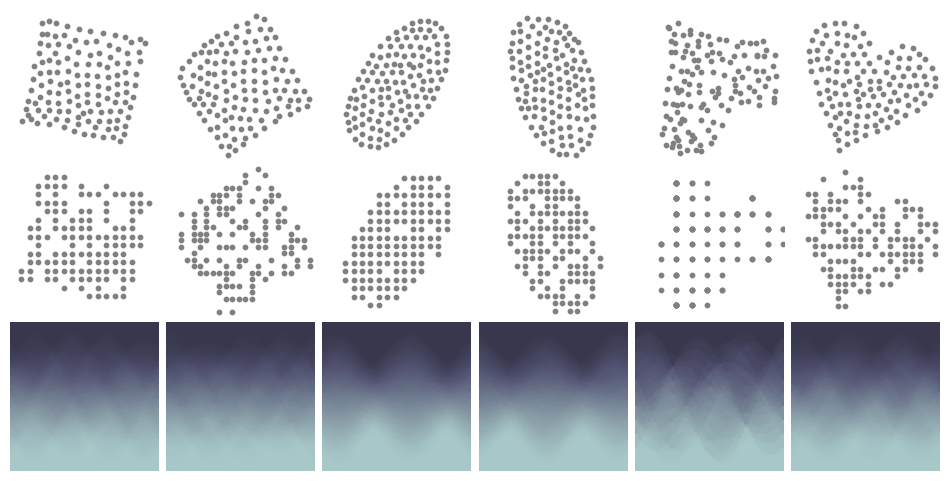

In [31]:

ect = layer(batch,batch.batch).unsqueeze(1)

with torch.no_grad():
    recon_batch = ect_encoder_litmodel.model.forward(ect)

fig,axes = plt.subplots(3,6,figsize=(12,6))
fig.subplots_adjust(wspace=0.05,hspace=0.05)
for idx, (ecc, ax) in enumerate(zip(ect,axes.T)):
    pts_recon = recon_batch[idx].view(128,2).detach().cpu().numpy()
    pts = batch[idx].x.detach().cpu().numpy()

    ax[0].scatter(pts_recon[:,0],pts_recon[:,1],**PC_PLOT_CONFIG)
    ax[0].set_xlim([-1,1])
    ax[0].set_ylim([-1,1])
    ax[0].axis("off")
    
    ax[1].scatter(pts[:,0],pts[:,1],**PC_PLOT_CONFIG)
    ax[1].set_xlim([-1,1])
    ax[1].set_ylim([-1,1])
    ax[1].axis("off")
    ax[2].imshow(ecc.detach().cpu().squeeze().numpy(),**ECT_PLOT_CONFIG)
    ax[2].axis("off")

plt.savefig("./figures/img/dsprites/reconstructed_all.svg",transparent=True)

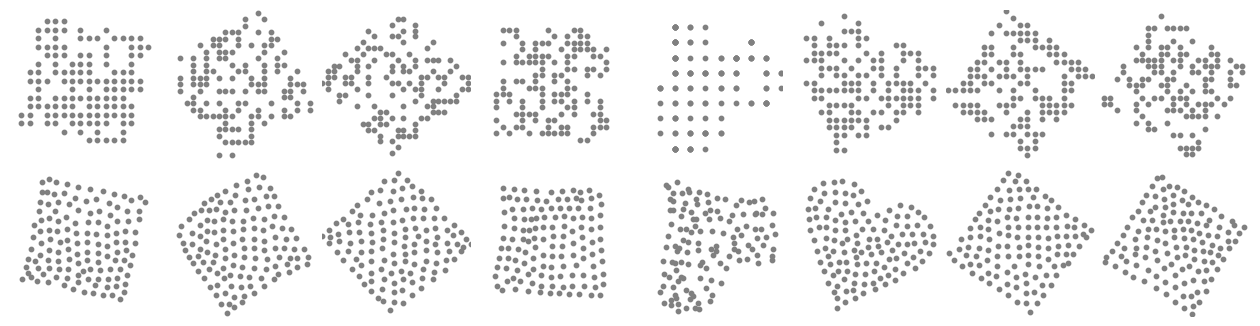

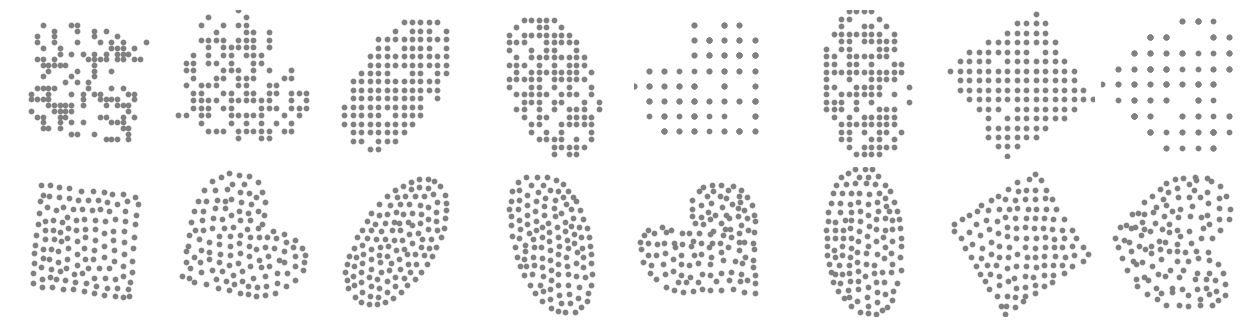

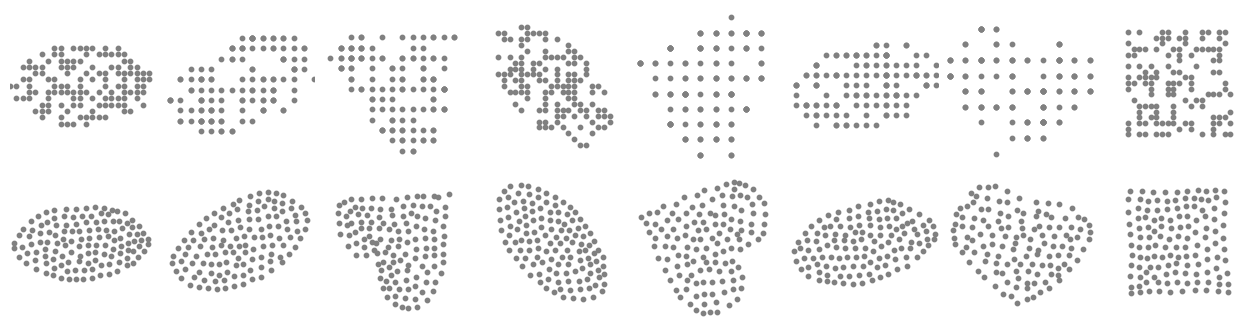

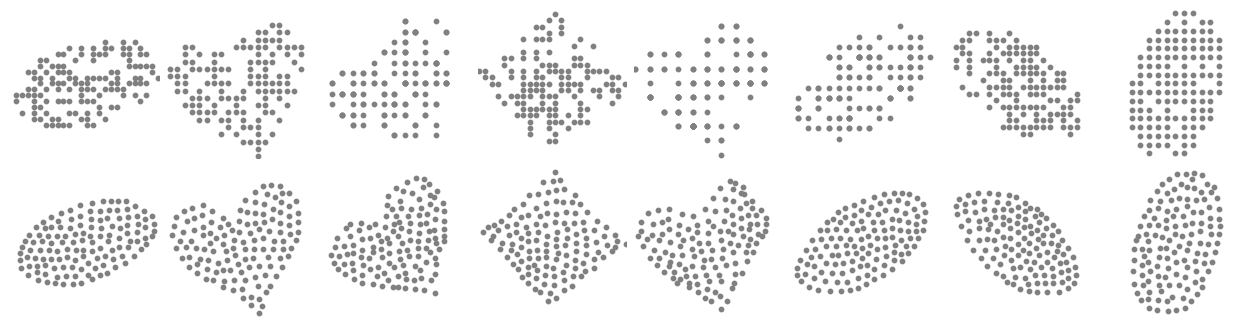

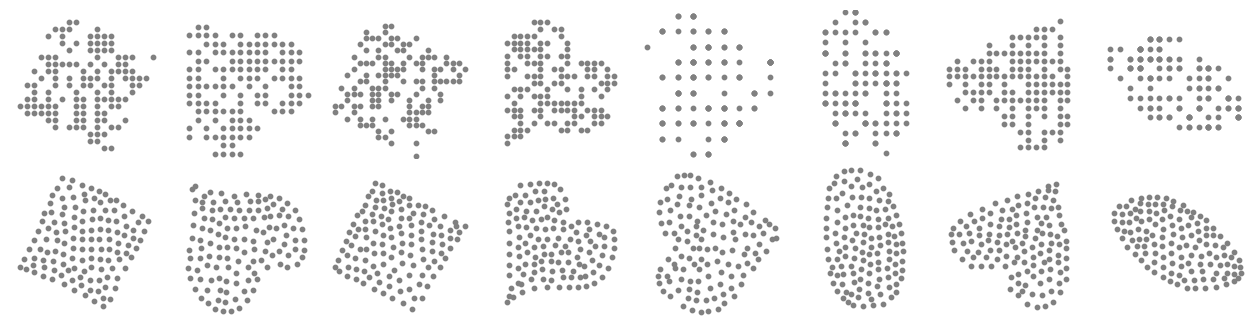

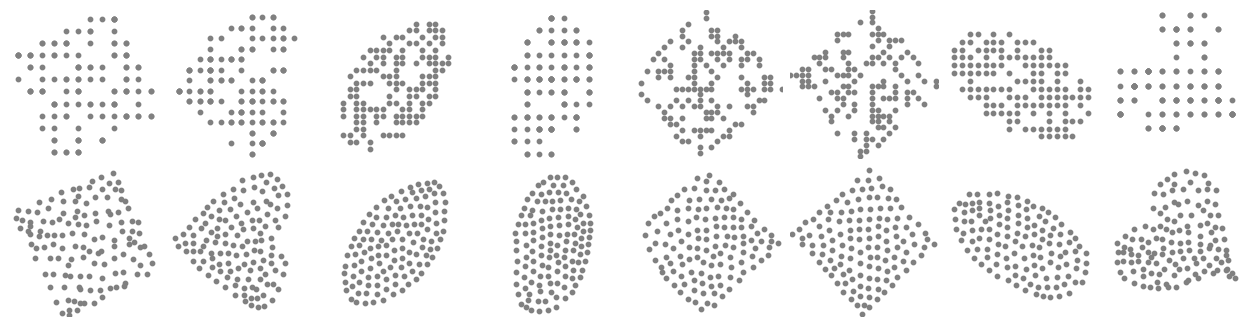

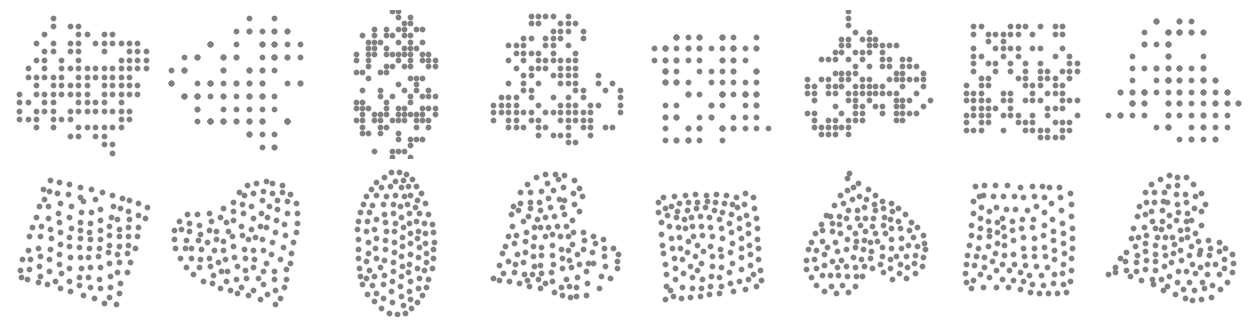

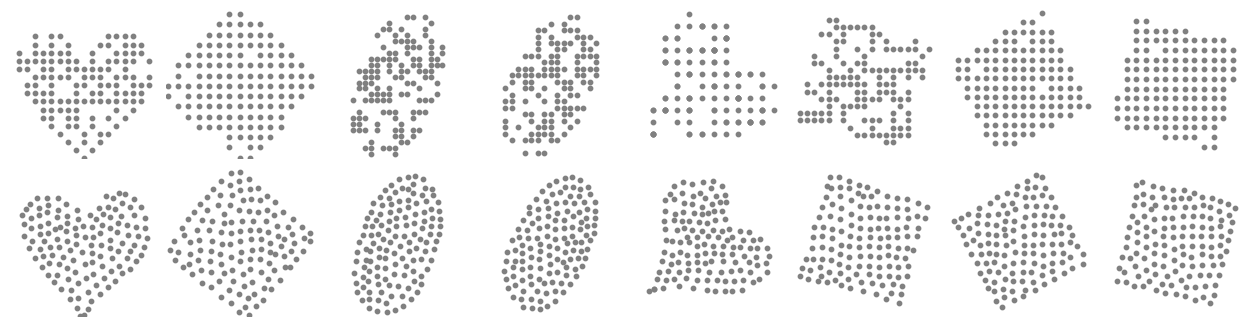

In [29]:
for batch_idx, features in enumerate(dm.val_dataloader()):
    break

features = features.to(DEVICE)
features_ect = layer(features,features.batch).unsqueeze(1)

with torch.no_grad():
    features_recon_batch = ect_encoder_litmodel.model.forward(features_ect)

n_images = 8

for idx in range(0,64,8):
    fig, axes = plt.subplots(
        nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=(16,4)
    )
    fig.subplots_adjust(wspace=0.05,hspace=0.05)


    for batch_idx, (recon_pts,ax) in enumerate(zip(features_recon_batch[idx::],axes.T)):
        # print(recon_pts_x.shape)
        pts = features[idx + batch_idx].x.detach().cpu().numpy()
        recon_pts = recon_pts.view(-1,2).cpu().detach().squeeze().numpy()
        # recon_pts = rotate(recon_pts, degrees=-90)

        ax[0].scatter(pts[:,0],pts[:,1],**PC_PLOT_CONFIG)
        ax[0].set_xlim([-1,1])
        ax[0].set_ylim([-1,1])
        ax[0].set_aspect(1)
        ax[0].axis("off")

        ax[1].scatter(recon_pts[:,0],recon_pts[:,1],**PC_PLOT_CONFIG)
        ax[1].set_xlim([-1,1])
        ax[1].set_ylim([-1,1])
        ax[1].set_aspect(1)
        ax[1].axis("off")

        
